In [1]:
import pandas as pd
import numpy as np

In [2]:
START, END = '2021-1-1', '2021-11-25'
data_tweet = pd.read_csv("covidvaccine_tweet_sentiment.csv", index_col=['date'], parse_dates=['date'])
data_vaccine = pd.read_csv("COVID-19_Vaccination_Trends_Population.csv", index_col=['Date'], parse_dates=['Date'], thousands=',')
data_tweet = data_tweet.loc[START:END]
data_vaccine = data_vaccine.loc[START:END]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  after removing the cwd from sys.path.


In [3]:
# Divided by states
vaccine_by_state = {}
tweet_by_state = {}
locs = data_tweet['user_location'].unique()
for i in range(len(locs)):
    loc = locs[i]
    tmp = data_tweet[data_tweet['user_location'] == loc]
    if len(tmp) > 500:
        tweet_by_state[loc] = tmp
        vaccine_by_state[loc] = data_vaccine[data_vaccine['Location']==loc]

In [4]:
# TODO Calculate Tweet Impact
def tweet_impact(state, f1):
    table = tweet_by_state[state]
    impact = (f1 * np.log(table['user_followers'])) * table['sentiment_score']
    # impact = table['sentiment_score']
    return impact.resample('1D').mean()

In [ ]:
F1 = 0.8
WINDOW = '7D'

from matplotlib import pyplot as plt
impact_score = []
vaccination_rate = []
for state in tweet_by_state:
    # Calculate Tweet Impact
    date_idx = pd.date_range(start=START, end=END, freq='1D')
    series = pd.Series(index=date_idx, dtype='object')
    tmp = tweet_impact(state, F1).ewm(com=0.7).mean()
    series[tmp.index] = tmp
    series.interpolate(method='polynomial', order=2, inplace=True)
    series = series.resample(WINDOW).mean()
    impact_score.append(series)
    # impact_score.append(series[:-2]) # interploate cannot fill last few values
    
    # Calculate vaccination rate
    vaccine = vaccine_by_state[state]
    # TODO Chooses "Administration" or "Report" date type
    vaccine = vaccine[vaccine['date_type'] == "Admin"]
    vaccine = vaccine.resample(WINDOW).mean()
    vaccine = vaccine.ewm(com=2).mean()
    vaccination_rate.append(vaccine['Administered_Daily'] / vaccine['Population'] * 100)

plt.plot(impact_score[4].index, impact_score[4])
impact_score = np.array(impact_score)
vaccination_rate = np.array(vaccination_rate)

In [6]:
print(impact_score.shape)
print(vaccination_rate.shape)

(33, 47)
(33, 47)


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
## Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [12]:
x_train = impact_score.reshape(-1,1)
y_train = vaccination_rate.reshape(-1,1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, shuffle=True, train_size=0.8)

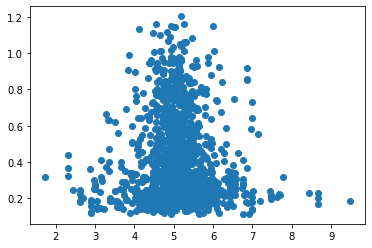

In [13]:
plt.scatter(x_train, y_train, marker='o')

In [15]:
poly = PolynomialFeatures(2)
reg = LinearRegression()
reg.fit(poly.fit_transform(x_train), y_train)
reg.score(poly.fit_transform(x_valid), y_valid)

0.014580203527522984